In [1]:
pip install lightgbm



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.impute import SimpleImputer

c:\Users\Belen Lugo\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Cargar el dataset
df=pd.read_csv('../data/train.csv')

In [4]:
# Mostrar las primeras filas del dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [13]:
# Informacion general de dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [14]:
# Estadisticas generales
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [15]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

#### 1. Limpieza de datos
Manejo de valores faltantes

In [16]:
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False).head(20)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
Self_Employed,582,32,5.21
LoanAmount,592,22,3.58
Dependents,599,15,2.44
Loan_Amount_Term,600,14,2.28
Gender,601,13,2.12
Married,611,3,0.49
Loan_ID,614,0,0.00
Education,614,0,0.00
ApplicantIncome,614,0,0.00


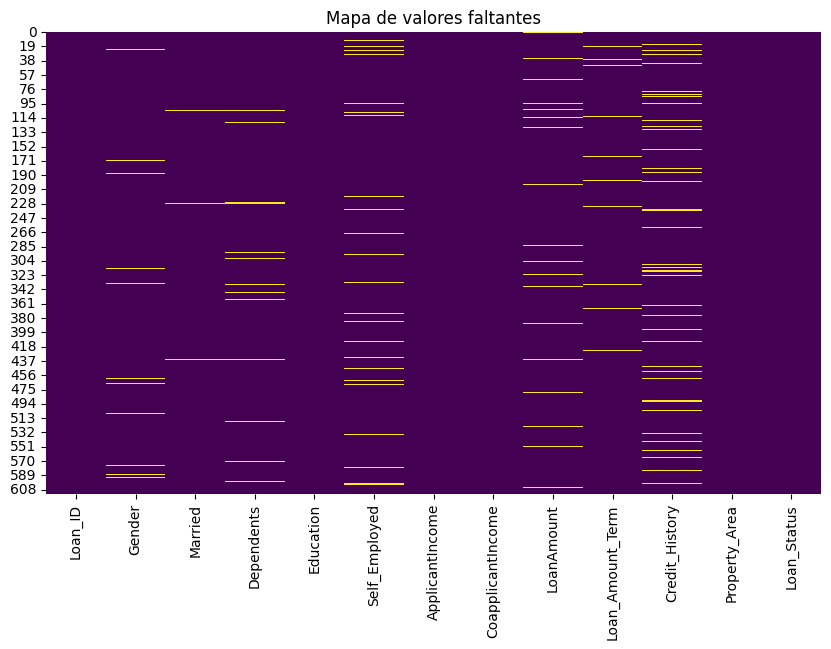

In [18]:
# Visualizar distribución de valores faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de valores faltantes")
plt.show()

Imputacion de valores faltantes

1. Credit_History (8.14% de valores faltantes)
Descripción: Indica si el solicitante tiene un historial crediticio favorable.
Imputación: Dado que esta variable es binaria (sí/no), he decidido imputar los valores faltantes con la moda (el valor más frecuente). Si la mayoría de los solicitantes tienen un buen historial crediticio (valor "1"), se podria asumir que los valores faltantes deberían ser "1".

2. Self_Employed (5.21% de valores faltantes)
Descripción: Indica si el solicitante es autoempleado.
Imputación: Al ser una variable categórica binaria, se puede imputar los valores faltantes con la moda (el valor más frecuente). Si la mayoría de los solicitantes no son autoempleados (valor "No"), puedes imputar los valores faltantes con "No".

3. LoanAmount (3.58% de valores faltantes)
Descripción: El monto del préstamo en miles.
Imputación: He decido imputar los valores faltantes con la mediana de la variable, ya que los valores atípicos pueden afectar el promedio. La mediana es una buena opción en este caso, ya que representa mejor la tendencia central en este tipo de variables numéricas.

4. Dependents (2.44% de valores faltantes)
Descripción: Número de dependientes.
Imputación: Al ser una variable numérica discreta, se imputar con la moda de los valores. Si la mayoría de los solicitantes tienen 0 o 1 dependientes, se puede imputar con la moda de esa variable.

5. Loan_Amount_Term (2.28% de valores faltantes)
Descripción: El término del préstamo en meses.
Imputación: Dado que esta es una variable numérica, se puede imputar con la moda o la mediana. Lo más probable es que la mayoría de los préstamos tengan un término similar, por lo que la moda podría ser una opción útil.

6. Gender (2.12% de valores faltantes)
Descripción: Género del solicitante.
Imputación: Se puede imputar con la moda, ya que es una variable categórica binaria. Si la mayoría de los solicitantes son de un género específico (por ejemplo, "Male" o "Female"), se puede usar ese valor para completar los valores faltantes.

7. Married (0.49% de valores faltantes)
Descripción: Estado civil del solicitante (casado/no casado).
Imputación: Al ser una variable binaria, se puede imputar con la moda (el valor más frecuente). Si la mayoría de los solicitantes están casados, se puede imputar con "Yes".

In [5]:
# Función para imputar valores
def imputar_valores(df):
    imputaciones = {
        'Credit_History': df['Credit_History'].mode()[0],  # Moda
        'Self_Employed': df['Self_Employed'].mode()[0],    # Moda
        'LoanAmount': df['LoanAmount'].median(),           # Mediana
        'Dependents': df['Dependents'].mode()[0],          # Moda
        'Loan_Amount_Term': df['Loan_Amount_Term'].mode()[0],  # Moda
        'Gender': df['Gender'].mode()[0],                  # Moda
        'Married': df['Married'].mode()[0]                 # Moda
    }

    for column, value in imputaciones.items():
        df[column].fillna(value, inplace=True)
    return df

# Aplicar imputaciones
data_imputed = imputar_valores(df.copy())

# Verificar los valores faltantes tras la imputación
data_imputed.isnull().sum()


C:\Users\Belen Lugo\AppData\Local\Temp\ipykernel_12016\1611290266.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(value, inplace=True)


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
# =====================================
# Preprocesamiento actualizado
# =====================================

# Identificar columnas categóricas y numéricas
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Tratamiento de valores faltantes
from sklearn.impute import SimpleImputer

imputer_categorical = SimpleImputer(strategy="most_frequent")
imputer_numeric = SimpleImputer(strategy="median")

df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])
df[numerical_columns] = imputer_numeric.fit_transform(df[numerical_columns])

# Codificación de variables categóricas y escalado
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X = df.drop(columns=["Loan_ID", "Loan_Status"])
y = df["Loan_Status"].apply(lambda x: 1 if x == "Y" else 0)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(drop="first"), categorical_columns),
    ]
)

# =====================================
# Implementación del pipeline de LightGBM
# =====================================

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline para preprocesamiento y LightGBM
model = lgb.LGBMClassifier(random_state=42)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Entrenamiento inicial
pipeline.fit(X_train, y_train)

# Predicciones y evaluación inicial
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

initial_report = classification_report(y_test, y_pred)
initial_auc = roc_auc_score(y_test, y_pred_proba)

# =====================================
# Optimización de Hiperparámetros
# =====================================

from sklearn.model_selection import GridSearchCV

# Configurar GridSearchCV para LightGBM
param_grid = {
    "model__num_leaves": [31, 50],
    "model__learning_rate": [0.1, 0.01],
    "model__n_estimators": [100, 200],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", verbose=1)
grid_search.fit(X_train, y_train)

# Evaluación final
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)
y_pred_final_proba = best_model.predict_proba(X_test)[:, 1]

final_report = classification_report(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_final_proba)

# Resultados
print("Reporte inicial:")
print(initial_report)
print(f"ROC-AUC inicial: {initial_auc:.4f}\n")

print("Reporte final:")
print(final_report)
print(f"ROC-AUC final: {final_auc:.4f}")
print("Mejores hiperparámetros:", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 295, number of negative: 134
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.687646 -> initscore=0.789136
[LightGBM] [Info] Start training from score 0.789136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[